In [1]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import os

In [2]:
dt_labels = pd.read_csv('./Dataset/Labels.csv')
print(dt_labels.head())
print(dt_labels.shape)

                image  label
0  Img/img001-001.png      0
1  Img/img001-002.png      0
2  Img/img001-003.png      0
3  Img/img001-004.png      0
4  Img/img001-005.png      0
(550, 2)


In [17]:
image_paths = dt_labels['image']
images = []
for filename in os.listdir("./Dataset/Img"):
    img = cv2.imread(os.path.join("./Dataset/Img",filename), 0)
    if img is not None:
        images.append(img)
print("Loaded all images!")
train_X = np.array(images)
train_X = train_X.reshape(550, 900 * 1200)
train_X = train_X.transpose()
train_X = tf.math.divide(train_X, 255)
print(train_X.shape)
print("All the training set it's ready")

Loaded all images!
(1080000, 550)
All the training set it's ready


In [69]:
train_Y = tf.one_hot(dt_labels['label'], 9)
train_Y = tf.transpose(train_Y)
print(train_Y)

tf.Tensor(
[[1. 1. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(9, 550), dtype=float32)


In [41]:
def initialize_parameters(layers):
    # Define He Initializer for ReLu activations and GlorotNormal for last unit that will be a sigmoid activation
    initializerHe = tf.keras.initializers.HeNormal(seed=1)
    initializerGn = tf.keras.initializers.GlorotNormal(seed=1)
    
    parameters = {}
    dims = len(layers) - 1
    
    for i in range(1, dims):
        parameters["W" + str(i)] = tf.Variable(initializerHe(shape=(layers[i], layers[i-1])))
        parameters["b" + str(i)] = tf.Variable(initializerHe(shape=(layers[i], 1)))

    parameters["W" + str(dims)] = tf.Variable(initializerGn(shape=(layers[dims], layers[dims-1])))
    parameters["b" + str(dims)] = tf.Variable(initializerGn(shape=(layers[dims], 1)))
    
    return parameters

In [61]:
layers = [1080000, 5, 5, 9]
parameters = initialize_parameters(layers)
print(parameters)

{'W1': <tf.Variable 'Variable:0' shape=(5, 1080000) dtype=float32, numpy=
array([[ 0.09106225, -0.35448155,  0.4538295 , ...,  1.2204591 ,
         0.699147  , -0.00436594],
       [-0.8471499 ,  1.012885  ,  0.3756044 , ...,  0.69289434,
        -0.01809851, -0.13605206],
       [ 0.20540892, -1.1437447 ,  0.44322544, ..., -0.57866013,
         0.22023813,  1.1401178 ],
       [-0.5559414 , -0.43513256,  0.5033562 , ..., -0.14637862,
        -0.41265413,  0.10542125],
       [ 0.26351434,  0.5550274 ,  0.4324368 , ...,  0.2431362 ,
        -0.30402425,  0.07822501]], dtype=float32)>, 'b1': <tf.Variable 'Variable:0' shape=(5, 1) dtype=float32, numpy=
array([[ 0.09106225],
       [-0.35448155],
       [ 0.4538295 ],
       [-0.56718487],
       [-0.65419155]], dtype=float32)>, 'W2': <tf.Variable 'Variable:0' shape=(5, 5) dtype=float32, numpy=
array([[ 0.09106225, -0.35448155,  0.4538295 , -0.56718487, -0.65419155],
       [-0.28700176, -0.02740788,  0.33649984, -0.01077695, -1.0087425 ]

In [46]:
def forward_propagation(X, parameters, layers):
    dims = len(layers) - 1
    
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    Z_temp = tf.math.add(tf.linalg.matmul(W1,X), b1)
    A_temp = tf.keras.activations.relu(Z_temp)
    
    for i in range(2, dims):
        Z_temp = tf.math.add(tf.linalg.matmul(parameters["W" + str(i)],A_temp), parameters["b" + str(i)])
        A_temp = tf.keras.activations.relu(Z_temp)
        
    Z_temp = tf.math.add(tf.linalg.matmul(parameters["W" + str(dims)],A_temp), parameters["b" + str(dims)])
    A_temp = tf.keras.activations.sigmoid(Z_temp)

    return Z_temp

In [62]:
print(forward_propagation(train_X, parameters, layers))

tf.Tensor(
[[  40.548943    43.233776     7.8712244 ...   37.635017    76.63883
    97.82137  ]
 [  11.936734    17.915277    -8.5934105 ...   10.112913    31.435892
    39.719193 ]
 [  83.68943     71.97598     52.056187  ...   80.84569    119.83012
   110.68248  ]
 ...
 [  31.849731    32.246807     9.63714   ...   29.866707    57.62793
    88.92243  ]
 [-114.09012    -86.428345   -94.41898   ... -112.28903   -139.75758
  -201.54044  ]
 [ 133.1901      98.17475    116.12601   ...  131.61003    152.89886
   164.45055  ]], shape=(9, 550), dtype=float32)


In [93]:
def compute_cost(y_true, y_pred):
    y_pred = tf.transpose(y_pred)
    y_true = tf.reshape(tf.transpose(y_true),[y_pred.shape[0],9])
    cost =  tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_true, y_pred,from_logits=True))
    return cost

In [91]:
def model(X_train, Y_train, learning_rate = 0.0001, num_epochs = 1500, layers = [1], print_cost = True):
    
    # Save all the costs around the training
    costs = []
    
    # Initialize the parameters
    parameters = initialize_parameters(layers)
    trainable_variables = []
    for i in range(1, len(layers)-1):
        trainable_variables.append(parameters["W" + str(i)])
        trainable_variables.append(parameters["b" + str(i)])
    # print(trainable_variables)
    
    # I want to use the Adam optimizer in my model, in my experience, it's very efficient
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    for epoch in range(num_epochs):
        with tf.GradientTape() as tape:
            # Do the fordward propagation
            Z3 = forward_propagation(X_train, parameters, layers)

            # Compute the cost function
            cost = compute_cost(Y_train, Z3)

        grads = tape.gradient(cost, trainable_variables)
        optimizer.apply_gradients(zip(grads, trainable_variables))

        if print_cost == True and epoch % 10 == 0:
            print ("Cost after epoch %i: %f" % (epoch, cost))

        costs.append(cost)
    
    return parameters, costs

In [ ]:
num_epochsTrain = 100
parameters, costs = model(train_X, train_Y, learning_rate = 0.0001, layers=[1080000, 25, 10, 5, 9], num_epochs = num_epochsTrain)
plt.plot(np.arange(num_epochsTrain)+1, costs)
plt.xlabel("Iterations(m)")
plt.ylabel("Cost function(J)")
plt.show()

Cost after epoch 0: 364.527740


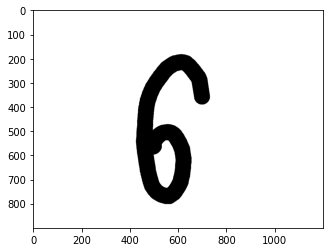

In [6]:
temp4 = train_X[:,346]
temp4 = temp4.reshape(900, 1200)
plt.gray()
plt.imshow(temp4)